# Installs

In [1]:
!pip install transformers
!pip install shap
!pip install lime
!pip install sentencepiece 
!pip install emoji
!pip install rouge_score
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=4bdde9624389b87fff297af1bd32593d03eb8d0588dccb7a7cdd681bf5952641
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Succe

In [2]:
# General purpose packages
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import pprint
import re
import seaborn as sns
from tqdm import tqdm
from pprint import pprint
from math import exp
from functools import partial
from typing import Any, Dict, List

# Required imports for the supervised models
import torch
import sentencepiece
import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification

# Required imports for the explainability frameworks
import shap
from lime.lime_text import LimeTextExplainer
from captum.attr import (LayerIntegratedGradients, ShapleyValueSampling, Occlusion, 
                         LayerDeepLiftShap, TokenReferenceBase, LayerGradientXActivation, LimeBase)
from captum._utils.models.linear_model import SkLearnLasso, SkLearnLinearModel

# Import to connect with google drive's content
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Define the configuration

In [3]:
# GLOBAL CONFIGURATION
IS_ALE       = False
BASE_PATH    = "drive/MyDrive/NLU Spring 2023 - Final Project" if IS_ALE else "drive/MyDrive/NYU/NLU Spring 2023 - Final Project"
DATA_PATH    = f"{BASE_PATH}/data"
RESULTS_PATH = f"{BASE_PATH}/results"
DATASET      = "1. Tweet Sentiment" # One of ["1. Tweet Sentiment", "2. Movie Rationales"] 
SUBSAMPLE    = True

SUPERVISED_MODELS = [
          "distilbert-base-uncased-finetuned-sst-2-english", # POSITIVE, NEGATIVE -  https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english
          "cardiffnlp/twitter-roberta-base-sentiment", # LABEL_0, LABEL_1, LABEL_2 - https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
          "ProsusAI/finbert", # Positive, Negative, Neutral - https://huggingface.co/ProsusAI/finbert 
          "cardiffnlp/twitter-xlm-roberta-base-sentiment", # Positive, Negative, Neutral - https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
          "finiteautomata/bertweet-base-sentiment-analysis", # Pos, Neu, Neg - https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis 
          "yiyanghkust/finbert-tone", # https://huggingface.co/yiyanghkust/finbert-tone
          ]

EMBEDDINGS = {'distilbert-base-uncased-finetuned-sst-2-english': 'model.distilbert.embeddings',
              'cardiffnlp/twitter-roberta-base-sentiment': 'model.roberta.embeddings',
              'ProsusAI/finbert': 'model.bert.embeddings',
              'cardiffnlp/twitter-xlm-roberta-base-sentiment': 'model.roberta.embeddings',
              'finiteautomata/bertweet-base-sentiment-analysis': 'model.roberta.embeddings',
              'cardiffnlp/twitter-roberta-base-sentiment-latest': 'model.roberta.embeddings',
              'yiyanghkust/finbert-tone': 'model.bert.embeddings',
              'j-hartmann/emotion-english-distilroberta-base': 'model.roberta.embeddings'}

N_EXPL_MODELS = 5

# 1. Load & Prep Data

## 1.1 Sentiment Datasets

In [4]:
train_data = pd.read_csv(f"{DATA_PATH}/{DATASET}/train.csv")
test_data  = pd.read_csv(f"{DATA_PATH}/{DATASET}/test.csv")

train_data  = train_data[train_data.sentiment != 'neutral'].reset_index(drop=True)
test_data   = test_data[test_data.sentiment != 'neutral'].reset_index(drop=True)

train_data[:1000].head(2)

,textID,text,selected_text,sentiment
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
1,088c60f138,my boss is bullying me...,bullying me,negative


## 1.2 Metrics Results

In [5]:
with open(f'{RESULTS_PATH}/consolidated_metrics.pickle', "rb") as input_file:
  results_df = pickle.load(input_file)

## 1.3 Enrichments

### 1.3.1 Gold Truth

- We have predicted_label but not gold_label
- Adding it so that we can compare being aware of whether explanations are ok or not

In [6]:
gold_sentiments_df = train_data[:1000][['text', 'sentiment']]
gold_sentiments_df.head(5)

,text,sentiment
0,Sooo SAD I will miss you here in San Diego!!!,negative
1,my boss is bullying me...,negative
2,what interview! leave me alone,negative
3,"Sons of ****, why couldn`t they put them on t...",negative
4,2am feedings for the baby are fun when he is a...,positive


In [7]:
results_df = gold_sentiments_df.merge(results_df, left_on='text', right_on='texts').drop(columns=['text']).rename(columns={'sentiment':'gold_label'})

assert results_df.shape[0] == results_df.shape[0]
results_df.head()

,gold_label,texts,selected_text,supervised_model,expl_framework,predicted_label,predicted_score,explanations,feature_agreement,rank_correlation,iou,pgi,pgu
0,negative,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,distilbert-base-uncased-finetuned-sst-2-english,dls,positive,0.9712993,"[(soo, 0.3549332), (##o, 0.30059725), (sad, 0....",0.75,0.712525,0.750000,0.014216,0.828882
1,negative,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,distilbert-base-uncased-finetuned-sst-2-english,lga,positive,0.9712993,"[(soo, 0.31141877), (##o, 0.1204984), (sad, -0...",0.25,0.323875,0.166667,0.970639,0.014108
2,negative,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,distilbert-base-uncased-finetuned-sst-2-english,lig,positive,0.9712993,"[(soo, -0.012404737950991807), (##o, 0.1181876...",0.50,0.496609,0.400000,0.011803,0.943905
3,negative,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,distilbert-base-uncased-finetuned-sst-2-english,svs,positive,0.9712993,"[(soo, -0.13176894), (##o, 0.16634446), (sad, ...",0.25,0.107958,0.166667,0.010338,0.014171
4,negative,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,distilbert-base-uncased-finetuned-sst-2-english,occlusion,positive,0.9712993,"[(soo, 0.0727059), (##o, 0.12056129), (sad, -0...",0.50,0.280692,0.400000,0.101122,0.010491


### 1.3.3 Length Gold Truth

In [8]:
split_by   = ' |(\.)|(!)'
tokenize   = lambda x: [token for token in re.split(split_by, x) if token]
len_tokens = lambda x: len([token for token in re.split(split_by, x) if token])
results_df['len_selected_text'] = results_df.apply(lambda row : len_tokens(row['selected_text']), axis = 1)
results_df['len_selected_text'].describe()

count    24000.00000
mean         4.14800
std          4.80136
min          1.00000
25%          1.00000
50%          2.00000
75%          5.00000
max         33.00000
Name: len_selected_text, dtype: float64

### 1.3.2 Top k Explanations

- Adding two fields for easier interpretation: 
    - 'explanations_top_k' (top k tokens according to explanation)
    - 'explanations_top_k_weighted' (tuples of top k tokens with its explanations weights)

In [9]:
k     = 4
#top_k = lambda explanation: sorted([explanation[i][0] for i in range(len(explanation))])[-k:]
top_k_weighted   = lambda explanation: sorted(explanation, key=lambda x: x[1])[-k:] 
top_k_unweighted = lambda explanation: [token for token,_ in sorted(explanation, key=lambda x: x[1])[-k:]] 
results_df['explanations_top_k_weighted'] = results_df.apply(lambda row : top_k_weighted(row['explanations']), axis = 1)
results_df['explanations_top_k']          = results_df.apply(lambda row : top_k_unweighted(row['explanations']), axis = 1)
#results_df['explanations_top_k_unweighted'].head()

In [10]:
results_df.explanations_top_k.head()

0      [will, ##o, soo, sad]
1    [you, diego, will, soo]
2        [##o, !, will, sad]
3         [in, i, ##o, will]
4        [soo, ##o, i, will]
Name: explanations_top_k, dtype: object

In [11]:
results_df.explanations_top_k_weighted.head()

0    [(will, 0.21889164), (##o, 0.30059725), (soo, ...
1    [(you, 0.1848618), (diego, 0.23099518), (will,...
2    [(##o, 0.11818761845681205), (!, 0.15467893583...
3    [(in, 0.07903138), (i, 0.11906659), (##o, 0.16...
4    [(soo, 0.0727059), (##o, 0.12056129), (i, 0.21...
Name: explanations_top_k_weighted, dtype: object

## 1.4 Bad Models/Predictions Indexes

- Bad model: model where the majority (>50%) of their predictions are wrong.In this case, the only model that lies there is: 'finiteautomata/bertweet-base-sentiment-analysis'

- Bad prediction: prediction where predicted label does not match the ground truth label. 

- For the purpose of the final analysis and insights, I will create 3 indexes to easily access the following subgroups of rows and be able to compare if any differences:
  - 'good_model_idx': indexes good models (ie accuracy >50%)
  - 'good_prediction_idx': indexes good predictions (ie ground truth label equals predicted label)
  - 'good_model_good_prediction_idx': indexes good models+good predictions.

In [12]:
results_df['good_prediction'] = results_df.predicted_label == results_df.gold_label
results_df.good_prediction.value_counts()

True     16740
False     7260
Name: good_prediction, dtype: int64

In [13]:
print('Wrong Predictions per model (out of 1000): ')
results_df[~ results_df.good_prediction].supervised_model.value_counts() / N_EXPL_MODELS

Wrong Predictions per model (out of 1000): 


finiteautomata/bertweet-base-sentiment-analysis    764.4
distilbert-base-uncased-finetuned-sst-2-english    242.4
cardiffnlp/twitter-roberta-base-sentiment          229.2
cardiffnlp/twitter-xlm-roberta-base-sentiment      216.0
Name: supervised_model, dtype: float64

Model "finiteautomata/bertweet-base-sentiment-analysis" is either very bad or our labels are flipped, however even if flipped we will have over 300 "wrong predictions". So for now I think I would remove this model from the analysis.

In [14]:
bad_models = ['finiteautomata/bertweet-base-sentiment-analysis']
results_df['good_model'] = ~results_df.supervised_model.isin(bad_models)#.reset_index(drop=True)
results_df[results_df.good_model].supervised_model.value_counts()

distilbert-base-uncased-finetuned-sst-2-english    6000
cardiffnlp/twitter-roberta-base-sentiment          6000
cardiffnlp/twitter-xlm-roberta-base-sentiment      6000
Name: supervised_model, dtype: int64

In [15]:
# Indexes to use during our analysis
good_model_idx                 = results_df['good_model']
good_prediction_idx            = results_df['good_prediction']
good_model_good_prediction_idx = good_model_idx & good_prediction_idx

In [16]:
results_df[good_model_idx].head(1)

,gold_label,texts,selected_text,supervised_model,expl_framework,predicted_label,predicted_score,explanations,feature_agreement,rank_correlation,iou,pgi,pgu,len_selected_text,explanations_top_k_weighted,explanations_top_k,good_prediction,good_model
0,negative,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,distilbert-base-uncased-finetuned-sst-2-english,dls,positive,0.9712993,"[(soo, 0.3549332), (##o, 0.30059725), (sad, 0....",0.75,0.712525,0.75,0.014216,0.828882,2,"[(will, 0.21889164), (##o, 0.30059725), (soo, ...","[will, ##o, soo, sad]",False,True


In [17]:
# Even when removing the bad model, we have a balanced number of predictions
results_df[good_model_good_prediction_idx].supervised_model.value_counts()

cardiffnlp/twitter-xlm-roberta-base-sentiment      4920
cardiffnlp/twitter-roberta-base-sentiment          4854
distilbert-base-uncased-finetuned-sst-2-english    4788
Name: supervised_model, dtype: int64

In [18]:
results_df[good_model_good_prediction_idx].expl_framework.value_counts()

dls          2427
lga          2427
lig          2427
svs          2427
occlusion    2427
random       2427
Name: expl_framework, dtype: int64

In [19]:
results_df.columns

Index(['gold_label', 'texts', 'selected_text', 'supervised_model',
       'expl_framework', 'predicted_label', 'predicted_score', 'explanations',
       'feature_agreement', 'rank_correlation', 'iou', 'pgi', 'pgu',
       'len_selected_text', 'explanations_top_k_weighted',
       'explanations_top_k', 'good_prediction', 'good_model'],
      dtype='object')

# 2. Metrics Descriptive Stats

## 2.0 Sorting+Renaming

- This is just for consistency across the charts + convenience on shorter names


In [20]:
# Sort by expl method order
results_df.expl_framework=pd.Categorical(results_df.expl_framework,categories=['random', 'dls', 'lga', 'lig', 'occlusion', 'svs'])
results_df = results_df.sort_values('expl_framework')

# Rename feature agreement
results_df.rename(columns={'feature_agreement': 'fa(k=4)'}, inplace=True, errors='raise')
results_df.columns

Index(['gold_label', 'texts', 'selected_text', 'supervised_model',
       'expl_framework', 'predicted_label', 'predicted_score', 'explanations',
       'fa(k=4)', 'rank_correlation', 'iou', 'pgi', 'pgu', 'len_selected_text',
       'explanations_top_k_weighted', 'explanations_top_k', 'good_prediction',
       'good_model'],
      dtype='object')

## 2.1 Single Metric Per Supervised Model

- As it can be seen, depending on the metric of interest, there is a different model that performs better overall:
  - For our models:distilbert having the best performance on: FA, IOU and PGU
  - twitter-roberta does the best for PGI (significantly better) and distibert the worst among all

In [21]:
# Means
results_df[results_df.expl_framework!='random'].groupby(['supervised_model'])['fa(k=4)','iou','pgi','pgu'].agg(['mean']).round(3) #min', 'max','mean', 'median', 'std'])

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,fa(k=4),iou,pgi,pgu
,mean,mean,mean,mean
supervised_model,,,,
cardiffnlp/twitter-roberta-base-sentiment,0.203,0.098,0.517,0.504
cardiffnlp/twitter-xlm-roberta-base-sentiment,0.238,0.126,0.246,0.241
distilbert-base-uncased-finetuned-sst-2-english,0.266,0.146,0.213,0.145
finiteautomata/bertweet-base-sentiment-analysis,0.243,0.136,0.327,0.312


In [22]:
# Std
results_df[results_df.expl_framework!='random'].groupby(['supervised_model'])['fa(k=4)','iou','pgi','pgu'].agg(['std']).round(3) #min', 'max','mean', 'median', 'std'])

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,fa(k=4),iou,pgi,pgu
,std,std,std,std
supervised_model,,,,
cardiffnlp/twitter-roberta-base-sentiment,0.358,0.198,0.263,0.258
cardiffnlp/twitter-xlm-roberta-base-sentiment,0.371,0.228,0.192,0.190
distilbert-base-uncased-finetuned-sst-2-english,0.385,0.239,0.354,0.296
finiteautomata/bertweet-base-sentiment-analysis,0.375,0.240,0.355,0.356


## 2.2 Single Metric per Expl Framework per model (Barchart section)

Insights looking across models:
- Seeing the two twitter models, it seems to be that twitter-xlm-roberta does much better on groud-truth faithfulness (FA, IOU) and PGU than its counterpart twitter-roberta, however, the latter has higher PGI on average. 
- TODO... 

In [23]:
show_model_metrics = lambda df, model_name: df[df.supervised_model==model_name].groupby(['supervised_model', 'expl_framework'])['fa(k=4)','iou','pgi','pgu'].agg(['mean']).round(3) 

### 2.2.1 cardiffnlp/twitter-roberta-base-sentiment

- Occlusion seems to be maximizing FA, IOU and PGI. 
- On PGU, top performer is LGA although not that significant with respect to the others.

In [24]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
show_model_metrics(results_df, model_name)

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


fa(k=4)    iou  \
                                                            mean   mean   
supervised_model                          expl_framework                  
cardiffnlp/twitter-roberta-base-sentiment random           0.156  0.071   
                                          dls              0.164  0.075   
                                          lga              0.162  0.076   
                                          lig              0.201  0.097   
                                          occlusion        0.251  0.123   
                                          svs              0.238  0.118   

                                                            pgi    pgu  
                                                           mean   mean  
supervised_model                          expl_framework                
cardiffnlp/twitter-roberta-base-sentiment random          0.502  0.498  
                                          dls             0.504  0.517  
                                          lga             0.521  0.486  
                                          lig             0.505  0.513  
                                          occlusion       0.532  0.503  
                                          svs             0.524  0.503

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


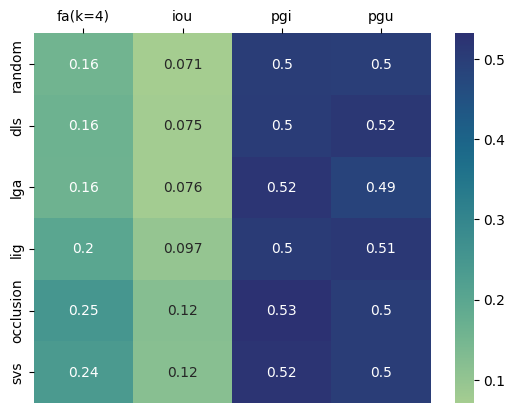

In [25]:
# Heatmap per model
model_name    = 'cardiffnlp/twitter-roberta-base-sentiment'
model_metrics = show_model_metrics(results_df, model_name)
model_metrics.columns = model_metrics.columns.get_level_values(0)
ax = sns.heatmap(model_metrics.loc[model_name], annot=True, cmap="crest") #set vmin and vmax if we want to fix the axes values 
ax.set(xlabel="", ylabel="") #Set ylabel=model_name if we want title
ax.xaxis.tick_top()

### 2.2.2 cardiffnlp/twitter-xlm-roberta-base-sentiment

- Occlusion seems to be best performer across all metrics (maximizing FA, IOU and PGI, minimizing PGU)

In [26]:
model_name = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
show_model_metrics(results_df, model_name)

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


fa(k=4)    iou  \
                                                                mean   mean   
supervised_model                              expl_framework                  
cardiffnlp/twitter-xlm-roberta-base-sentiment random           0.214  0.114   
                                              dls              0.233  0.123   
                                              lga              0.232  0.120   
                                              lig              0.240  0.127   
                                              occlusion        0.265  0.147   
                                              svs              0.218  0.113   

                                                                pgi    pgu  
                                                               mean   mean  
supervised_model                              expl_framework                
cardiffnlp/twitter-xlm-roberta-base-sentiment random          0.247  0.243  
                                              dls             0.238  0.249  
                                              lga             0.240  0.248  
                                              lig             0.237  0.239  
                                              occlusion       0.272  0.224  
                                              svs             0.244  0.243

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


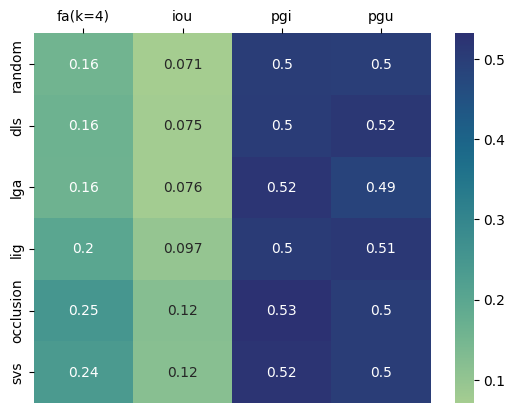

In [27]:
# Heatmap per model
model_name    = 'cardiffnlp/twitter-roberta-base-sentiment'
model_metrics = show_model_metrics(results_df, model_name)
model_metrics.columns = model_metrics.columns.get_level_values(0)
ax = sns.heatmap(model_metrics.loc[model_name], annot=True, cmap="crest") #set vmin and vmax if we want to fix the axes values 
ax.set(xlabel="", ylabel="") #Set ylabel=model_name if we want title
ax.xaxis.tick_top()

### 2.2.3 distilbert-base-uncased-finetuned-sst-2-english

- Occlusion outperforming for feature agreement+IOU, SVS for PGI and LGA for PGU.

In [28]:
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
show_model_metrics(results_df, model_name)

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


fa(k=4)    iou  \
                                                                  mean   mean   
supervised_model                                expl_framework                  
distilbert-base-uncased-finetuned-sst-2-english random           0.221  0.119   
                                                dls              0.243  0.132   
                                                lga              0.256  0.139   
                                                lig              0.278  0.154   
                                                occlusion        0.281  0.155   
                                                svs              0.270  0.152   

                                                                  pgi    pgu  
                                                                 mean   mean  
supervised_model                                expl_framework                
distilbert-base-uncased-finetuned-sst-2-english random          0.160  0.175  
                                                dls             0.189  0.151  
                                                lga             0.218  0.132  
                                                lig             0.210  0.146  
                                                occlusion       0.211  0.150  
                                                svs             0.237  0.144

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


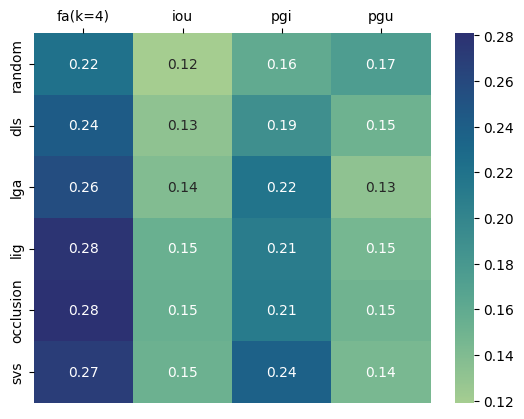

In [29]:
# Heatmap per model
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model_metrics = show_model_metrics(results_df, model_name)
model_metrics.columns = model_metrics.columns.get_level_values(0)
ax = sns.heatmap(model_metrics.loc[model_name], annot=True, cmap="crest") #set vmin and vmax if we want to fix the axes values 
ax.set(xlabel="", ylabel="") #Set ylabel=model_name if we want title
ax.xaxis.tick_top()

### 2.2.4 finiteautomata/bertweet-base-sentiment-analysis

- SVS outperforming (2nd occlusion) on FA
- SVS and Occlusion best performance on IOU
- Occlusion top performer on PGI
- LGA top performer on PGU

In [30]:
model_name = 'finiteautomata/bertweet-base-sentiment-analysis'
show_model_metrics(results_df, model_name)

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


fa(k=4)    iou  \
                                                                  mean   mean   
supervised_model                                expl_framework                  
finiteautomata/bertweet-base-sentiment-analysis random           0.205  0.116   
                                                dls              0.233  0.132   
                                                lga              0.232  0.131   
                                                lig              0.219  0.126   
                                                occlusion        0.262  0.146   
                                                svs              0.268  0.146   

                                                                  pgi    pgu  
                                                                 mean   mean  
supervised_model                                expl_framework                
finiteautomata/bertweet-base-sentiment-analysis random          0.317  0.298  
                                                dls             0.305  0.320  
                                                lga             0.355  0.283  
                                                lig             0.308  0.324  
                                                occlusion       0.346  0.310  
                                                svs             0.322  0.323

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


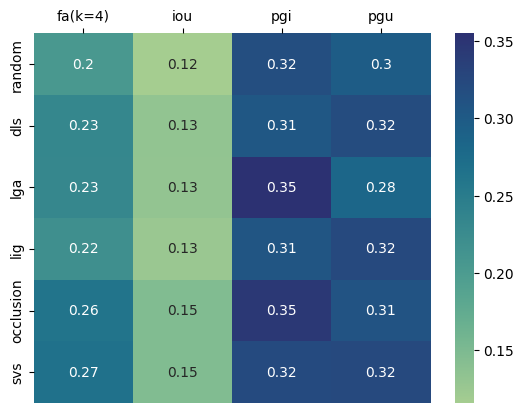

In [31]:
# Heatmap per model
model_name = 'finiteautomata/bertweet-base-sentiment-analysis'
model_metrics = show_model_metrics(results_df, model_name)
model_metrics.columns = model_metrics.columns.get_level_values(0)
ax = sns.heatmap(model_metrics.loc[model_name], annot=True, cmap="crest") #set vmin and vmax if we want to fix the axes values 
ax.set(xlabel="", ylabel="") #Set ylabel=model_name if we want title
ax.xaxis.tick_top()

## 2.3 Heatmaps for each metric


### 2.3.1 fa(k=4)

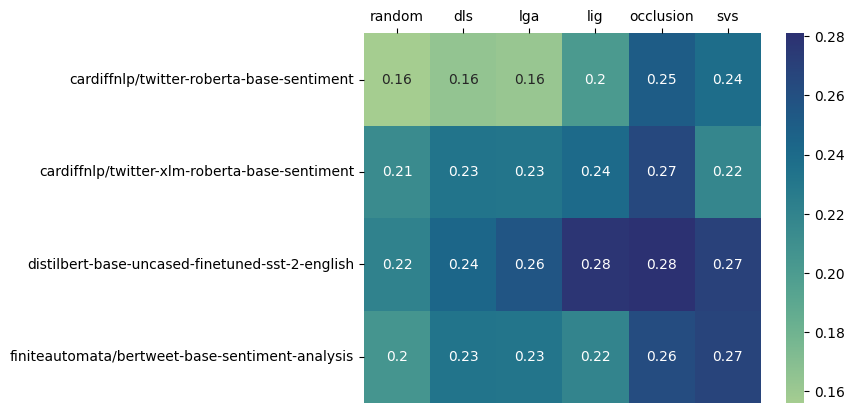

In [32]:
# Metric Per model/expl method
metric_name = 'fa(k=4)'
means       = results_df.groupby(['supervised_model', 'expl_framework'])[metric_name].agg(['mean'], axis=0).round(3) #min', 'max','mean', 'median', 'std'])
means       = means.reset_index().pivot(index='supervised_model', columns='expl_framework', values='mean')
ax = sns.heatmap(means, annot=True, cmap="crest") #vmin=50, vmax=100) 
ax.set(xlabel="", ylabel='') #ylabel = metric_name)
ax.xaxis.tick_top()

### 2.3.2 IOU

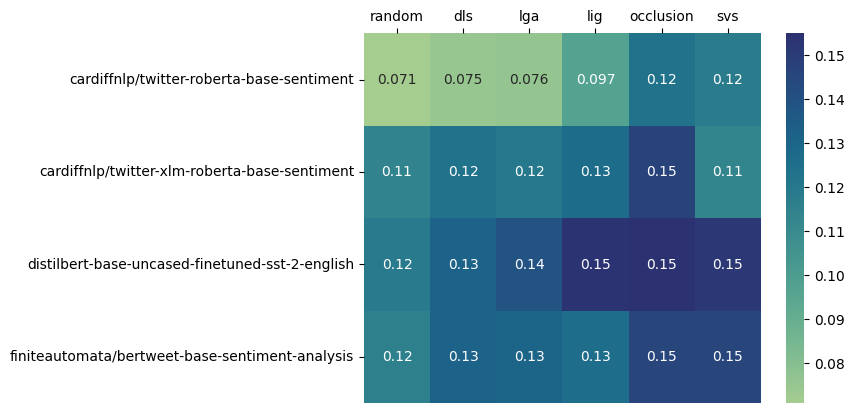

In [33]:
# Metric Per model/expl method
metric_name = 'iou'
means       = results_df.groupby(['supervised_model', 'expl_framework'])[metric_name].agg(['mean'], axis=0).round(3) #min', 'max','mean', 'median', 'std'])
means       = means.reset_index().pivot(index='supervised_model', columns='expl_framework', values='mean')
ax = sns.heatmap(means, annot=True, cmap="crest") #vmin=50, vmax=100) 
ax.set(xlabel="", ylabel='') #ylabel = metric_name)
ax.xaxis.tick_top()

### 2.3.3 PGI

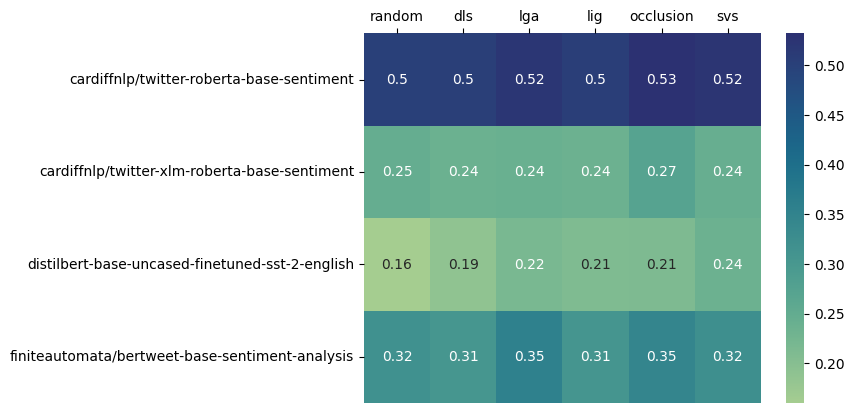

In [34]:
# Metric Per model/expl method
metric_name = 'pgi'
means       = results_df.groupby(['supervised_model', 'expl_framework'])[metric_name].agg(['mean'], axis=0).round(3) #min', 'max','mean', 'median', 'std'])
means       = means.reset_index().pivot(index='supervised_model', columns='expl_framework', values='mean')
ax = sns.heatmap(means, annot=True, cmap="crest") #vmin=50, vmax=100) 
ax.set(xlabel="", ylabel='') #ylabel = metric_name)
ax.xaxis.tick_top()

### 2.3.4 PGU

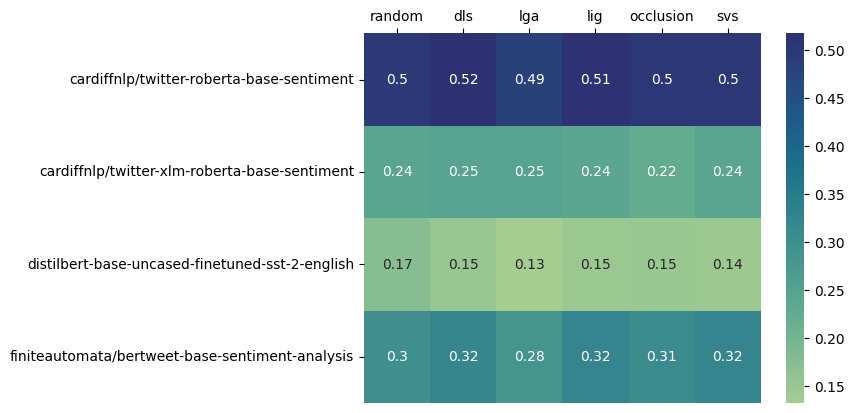

In [35]:
# Metric Per model/expl method
metric_name = 'pgu'
means       = results_df.groupby(['supervised_model', 'expl_framework'])[metric_name].agg(['mean'], axis=0).round(3) #min', 'max','mean', 'median', 'std'])
means       = means.reset_index().pivot(index='supervised_model', columns='expl_framework', values='mean')
ax = sns.heatmap(means, annot=True, cmap="crest") #vmin=50, vmax=100) 
ax.set(xlabel="", ylabel='') #ylabel = metric_name)
ax.xaxis.tick_top()

# 3 Individual sample analysis

In [36]:
# Columns to be used for analysis
cols  = ['supervised_model', 'expl_framework','selected_text','explanations_top_k', 'explanations','fa(k=4)', 'iou', 'pgi', 'pgu']

# Returns all elements of the df that share the same text and model
by_text                 = lambda df, cols, sample: df[(results_df['texts'] == sample.texts)][cols]
by_text_and_model       = lambda df, cols, sample: df[(results_df['texts'] == sample.texts) & (df['supervised_model'] == sample.supervised_model)][cols]
by_text_and_expl_method = lambda df, cols, sample: df[(results_df['texts'] == sample.texts) & (df['expl_framework']   == sample.expl_framework)][cols]


In [46]:
# Choosing a sample randomly for demo purposes
sample  = results_df[results_df['fa(k=4)'] > .95].iloc[16]
sample

gold_label                                                              negative
texts                                              my nail broke  I haaaaaaaaate
selected_text                                      my nail broke  I haaaaaaaaate
supervised_model                 distilbert-base-uncased-finetuned-sst-2-english
expl_framework                                                            random
predicted_label                                                         negative
predicted_score                                                       0.90889686
explanations                   [(my, -0.9313673354456737), (nail, 0.515639108...
fa(k=4)                                                                      1.0
rank_correlation                                                             NaN
iou                                                                          0.4
pgi                                                                     0.003587
pgu                         

In [53]:
sample  = results_df[results_df.texts== 'im soo bored...im deffo missing my music channels'].iloc[16]

results_df[results_df.texts== 'im soo bored...im deffo missing my music channels']

,gold_label,texts,selected_text,supervised_model,expl_framework,predicted_label,predicted_score,explanations,fa(k=4),rank_correlation,iou,pgi,pgu,len_selected_text,explanations_top_k_weighted,explanations_top_k,good_prediction,good_model
2806,negative,im soo bored...im deffo missing my music channels,bored..,cardiffnlp/twitter-xlm-roberta-base-sentiment,random,negative,0.8437804,"[(▁im, -0.9635555732321877), (▁soo, 0.11158799...",0.00,-0.455842,0.000000,0.093408,0.001267,3,"[(▁de, 0.12395506204262818), (ffo, 0.156064936...","[▁de, ffo, ▁music, im]",True,True
2805,negative,im soo bored...im deffo missing my music channels,bored..,cardiffnlp/twitter-roberta-base-sentiment,random,negative,0.88352424,"[(im, -0.9635555732321877), (Ġso, 0.1115879988...",0.00,-0.341882,0.000000,0.597725,0.352700,3,"[(Ġde, 0.12395506204262818), (ff, 0.1560649360...","[Ġde, ff, Ġmy, im]",True,True
2804,negative,im soo bored...im deffo missing my music channels,bored..,distilbert-base-uncased-finetuned-sst-2-english,random,negative,0.9976128,"[(im, -0.9635555732321877), (soo, 0.1115879988...",0.25,-0.044544,0.166667,0.000032,0.000225,3,"[(im, 0.12395506204262818), (def, 0.1560649360...","[im, def, my, .]",True,True
2807,negative,im soo bored...im deffo missing my music channels,bored..,finiteautomata/bertweet-base-sentiment-analysis,random,None,0.8514539,"[(im, -0.9635555732321877), (soo, 0.1115879988...",0.00,-0.400000,0.000000,0.050164,0.163586,3,"[(deffo, 0.12395506204262818), (missing, 0.156...","[deffo, missing, channels, im]",False,False
2784,negative,im soo bored...im deffo missing my music channels,bored..,distilbert-base-uncased-finetuned-sst-2-english,dls,negative,0.9976128,"[(im, -0.1612541), (soo, 0.047430098), (bored,...",0.25,0.044544,0.166667,0.003989,0.000127,3,"[(##fo, 0.106021926), (music, 0.13887194), (bo...","[##fo, music, bored, my]",True,True
2789,negative,im soo bored...im deffo missing my music channels,bored..,cardiffnlp/twitter-roberta-base-sentiment,dls,negative,0.88352424,"[(im, 0.0), (Ġso, -0.5628489), (o, -0.25202057...",0.00,-0.113961,0.000000,0.515559,0.744506,3,"[(o, 0.26199028), (Ġde, 0.26548672), (Ġmissing...","[o, Ġde, Ġmissing, ...]",True,True
2799,negative,im soo bored...im deffo missing my music channels,bored..,finiteautomata/bertweet-base-sentiment-analysis,dls,None,0.8514539,"[(im, 0.0), (soo, -0.2879325), (bor@@, -0.6715...",0.00,-0.500000,0.000000,0.167342,0.053931,3,"[(im, 0.0), (ed.@@, 0.05315532), (..@@, 0.0557...","[im, ed.@@, ..@@, im]",False,False
2794,negative,im soo bored...im deffo missing my music channels,bored..,cardiffnlp/twitter-xlm-roberta-base-sentiment,dls,negative,0.8437804,"[(▁im, 0.0), (▁soo, 0.14163671), (▁bor, 0.2734...",0.00,0.000000,0.000000,0.078191,0.541395,3,"[(▁soo, 0.14163671), (▁de, 0.15104836), (▁bor,...","[▁soo, ▁de, ▁bor, im]",True,True
2790,negative,im soo bored...im deffo missing my music channels,bored..,cardiffnlp/twitter-roberta-base-sentiment,lga,negative,0.88352424,"[(im, 0.6597536), (Ġso, 0.28230536), (o, 0.242...",0.00,0.341882,0.000000,0.665396,0.732312,3,"[(Ġde, 0.16908063), (o, 0.24241352), (Ġso, 0.2...","[Ġde, o, Ġso, im]",True,True
2785,negative,im soo bored...im deffo missing my music channels,bored..,distilbert-base-uncased-finetuned-sst-2-english,lga,negative,0.9976128,"[(im, -0.23501037), (soo, 0.12778339), (bored,...",0.50,0.267261,0.400000,0.003223,0.000219,3,"[(., 0.14147504), (def, 0.1845306), (bored, 0....","[., def, bored, my]",True,True


In [51]:
results_df[results_df.texts!=results_df.selected_text].texts.unique()

array(['Some goodies bagged at the car boot including some very cute cross stitch birds for my craft room! The man selling was a sweetie',
       ' This was funny! I have 7.', ' rofl uh huh',
       ' well doesn`t that look fab, even if I do say so myself!',
       ' you`re so gorgeous!!',
       '  Yeah I`m okay been icing and ace bandage and sitting on my **** on twitter... LOL Thanks',
       ' I loved him and he was in a mini',
       'Finally a chance to show genuine love, not dependent selfish love, I hope I can do it. My heart goes out to you and I`m sorry 4 ur pain.',
       'Working up to my vacation to Thailand. Getting more excited every day',
       ' good luck!! How exciting',
       'Finally sunny days and I`m too sick to go outside and play.',
       'Two months ago, I became irrelevant.',
       'has a terrible headache.  I need relief!',
       ' SherriEShepherd gave the link for  http://www.brentozar.com/twitter. He gives Twitter tips. Hope this helps',
       'In the

In [61]:
sample  = results_df[(results_df.supervised_model=='distilbert-base-uncased-finetuned-sst-2-english') & (results_df.pgi > .9)].iloc[0]#(results_df.texts== 'im soo bored...im deffo missing my music channels')].iloc[1]
sample
#by_text_and_model(results_df, cols, sample)

gold_label                                                              negative
texts                                       Two months ago, I became irrelevant.
selected_text                                                        irrelevant.
supervised_model                 distilbert-base-uncased-finetuned-sst-2-english
expl_framework                                                            random
predicted_label                                                         negative
predicted_score                                                        0.9963223
explanations                   [(two, 0.4613506443337121), (months, -0.975920...
fa(k=4)                                                                      0.0
rank_correlation                                                       -0.507093
iou                                                                          0.0
pgi                                                                     0.982256
pgu                         

In [62]:
# We can see at an individual level how an explanation changes across methods given a fixed model

# WE can see from above that: 
- FA is directly affected by the length that we select in K (e.g. the larger the K the higher the chance the word will be in the explanation) and at the same time, 
- FA and IOU are highly affected by the choice of K selected as hyperparameter. In this case where the gold explanation is one word, we can see that as long as that 
single word is among the top K, FA and IOU will give the top performance (1). On the other side, if explanations tend to be large and K rather small, then FA or IOU
max value will be lower because there is no way the overlap is full.

On the otherside, if we look at PGI and PGU, while it is stil dependant on K, 

by_text_and_model(results_df, cols, sample)

,supervised_model,expl_framework,selected_text,explanations_top_k,explanations,fa(k=4),iou,pgi,pgu
10388,distilbert-base-uncased-finetuned-sst-2-english,random,irrelevant.,"[,, ago, two, became]","[(two, 0.4613506443337121), (months, -0.975920...",0.0,0.0,0.982256,0.000043
10368,distilbert-base-uncased-finetuned-sst-2-english,dls,irrelevant.,"[became, ., ,, two]","[(two, 0.46561462), (months, 0.13424799), (ago...",0.0,0.0,0.163647,0.000109
10369,distilbert-base-uncased-finetuned-sst-2-english,lga,irrelevant.,"[became, ., ,, two]","[(two, 0.6972257), (months, -0.04851095), (ago...",0.0,0.0,0.059508,0.000709
10370,distilbert-base-uncased-finetuned-sst-2-english,lig,irrelevant.,"[became, irrelevant, ,, .]","[(two, 0.05483362303959182), (months, 0.051141...",0.0,0.0,0.050694,0.000160
10372,distilbert-base-uncased-finetuned-sst-2-english,occlusion,irrelevant.,"[i, two, irrelevant, .]","[(two, 0.074054696), (months, 0.027286679), (a...",0.0,0.0,0.093753,0.000435
10371,distilbert-base-uncased-finetuned-sst-2-english,svs,irrelevant.,"[,, months, irrelevant, .]","[(two, -0.04987836), (months, 0.012460556), (a...",0.0,0.0,0.962170,0.000024


In [48]:
# Choosing a sample randomly for demo purposes
sample  = results_df[results_df['pgi'] > .95].iloc[16]
sample

gold_label                                                              negative
texts                                   seems to have disappeared out of my life
selected_text                           seems to have disappeared out of my life
supervised_model                 distilbert-base-uncased-finetuned-sst-2-english
expl_framework                                                            random
predicted_label                                                         negative
predicted_score                                                       0.99780995
explanations                   [(seems, -0.025034509589640264), (to, -0.13220...
fa(k=4)                                                                      1.0
rank_correlation                                                             NaN
iou                                                                          0.5
pgi                                                                     0.983467
pgu                         

In [49]:
by_text_and_model(results_df, cols, sample)

,supervised_model,expl_framework,selected_text,explanations_top_k,explanations,fa(k=4),iou,pgi,pgu
11492,distilbert-base-uncased-finetuned-sst-2-english,random,seems to have disappeared out of my life,"[life, of, my, disappeared]","[(seems, -0.025034509589640264), (to, -0.13220...",1.0,0.5,0.983467,0.001079
11472,distilbert-base-uncased-finetuned-sst-2-english,dls,seems to have disappeared out of my life,"[out, to, seems, my]","[(seems, 0.30501643), (to, 0.18124332), (have,...",1.0,0.5,0.029305,0.000256
11473,distilbert-base-uncased-finetuned-sst-2-english,lga,seems to have disappeared out of my life,"[out, of, to, seems]","[(seems, 0.5191091), (to, 0.23391642), (have, ...",1.0,0.5,0.105053,0.000032
11474,distilbert-base-uncased-finetuned-sst-2-english,lig,seems to have disappeared out of my life,"[of, to, out, disappeared]","[(seems, 0.11179824175459388), (to, 0.33411264...",1.0,0.5,0.992188,0.001000
11476,distilbert-base-uncased-finetuned-sst-2-english,occlusion,seems to have disappeared out of my life,"[life, seems, to, out]","[(seems, 0.14159079), (to, 0.4817459), (have, ...",1.0,0.5,0.002109,0.989223
11475,distilbert-base-uncased-finetuned-sst-2-english,svs,seems to have disappeared out of my life,"[disappeared, have, out, to]","[(seems, -0.005170945), (to, 0.5655437), (have...",1.0,0.5,0.994696,0.000404


In [39]:
# Top k explanations for a given text an model
by_text_and_expl_method(results_df, cols, sample)

,supervised_model,expl_framework,selected_text,explanations_top_k,explanations,fa(k=4),iou,pgi,pgu
10295,finiteautomata/bertweet-base-sentiment-analysis,random,rofl uh huh,"[huh, rofl, uh]","[(rofl, 0.38159284052936404), (uh, 0.778159636...",1.00,1.0,0.057074,0.057074
10294,cardiffnlp/twitter-xlm-roberta-base-sentiment,random,rofl uh huh,"[▁uh, h, ▁ro, fl]","[(▁ro, 0.38159284052936404), (fl, 0.7781596367...",0.75,0.8,0.119038,0.050585
10293,cardiffnlp/twitter-roberta-base-sentiment,random,rofl uh huh,"[Ġhuh, Ġuh, Ġro, fl]","[(Ġro, 0.38159284052936404), (fl, 0.7781596367...",0.00,0.0,0.341256,0.341256
10292,distilbert-base-uncased-finetuned-sst-2-english,random,rofl uh huh,"[huh, uh, ro, ##fl]","[(ro, 0.38159284052936404), (##fl, 0.778159636...",1.00,1.0,0.737654,0.737654


In [40]:
# Top k explanations for a given text and expl method
by_text(results_df, cols, sample)

,supervised_model,expl_framework,selected_text,explanations_top_k,explanations,fa(k=4),iou,pgi,pgu
10295,finiteautomata/bertweet-base-sentiment-analysis,random,rofl uh huh,"[huh, rofl, uh]","[(rofl, 0.38159284052936404), (uh, 0.778159636...",1.00,1.0,0.057074,0.057074
10294,cardiffnlp/twitter-xlm-roberta-base-sentiment,random,rofl uh huh,"[▁uh, h, ▁ro, fl]","[(▁ro, 0.38159284052936404), (fl, 0.7781596367...",0.75,0.8,0.119038,0.050585
10293,cardiffnlp/twitter-roberta-base-sentiment,random,rofl uh huh,"[Ġhuh, Ġuh, Ġro, fl]","[(Ġro, 0.38159284052936404), (fl, 0.7781596367...",0.00,0.0,0.341256,0.341256
10292,distilbert-base-uncased-finetuned-sst-2-english,random,rofl uh huh,"[huh, uh, ro, ##fl]","[(ro, 0.38159284052936404), (##fl, 0.778159636...",1.00,1.0,0.737654,0.737654
10287,finiteautomata/bertweet-base-sentiment-analysis,dls,rofl uh huh,"[rofl, uh, huh]","[(rofl, 0.0), (uh, 0.023739992), (huh, 0.13813...",1.00,1.0,0.057074,0.057074
10282,cardiffnlp/twitter-xlm-roberta-base-sentiment,dls,rofl uh huh,"[▁ro, ▁hu, fl, ▁uh]","[(▁ro, 0.0), (fl, 0.48218614), (▁uh, 0.7491187...",1.00,0.8,0.071310,0.105219
10277,cardiffnlp/twitter-roberta-base-sentiment,dls,rofl uh huh,"[Ġro, Ġuh, fl, Ġhuh]","[(Ġro, 0.0), (fl, 0.39204517), (Ġuh, 0.3831575...",0.00,0.0,0.341256,0.341256
10272,distilbert-base-uncased-finetuned-sst-2-english,dls,rofl uh huh,"[uh, huh, ##fl, ro]","[(ro, 0.5985419), (##fl, 0.08779206), (uh, -0....",1.00,1.0,0.737654,0.737654
10288,finiteautomata/bertweet-base-sentiment-analysis,lga,rofl uh huh,"[uh, huh, rofl]","[(rofl, 0.44999063), (uh, 0.1422347), (huh, 0....",1.00,1.0,0.057074,0.057074
10283,cardiffnlp/twitter-xlm-roberta-base-sentiment,lga,rofl uh huh,"[h, ▁hu, ▁ro, fl]","[(▁ro, -0.09114122), (fl, 0.20295222), (▁uh, -...",1.00,0.8,0.071310,0.105219
